### Import Libraries

In [42]:
import sys
sys.path.insert(1, '../scripts')
import extended_model
import analysis_helper
import importlib
import glob
import json
importlib.reload(extended_model)
importlib.reload(analysis_helper)

import pandas as pd
import numpy as np
import bisect
import itertools
from functools import reduce
from operator import mul
from scipy.stats import norm
import random
from math import comb

import multiprocessing as mp

from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

## Vanilla Rewiring Only
Does not incorporate homophily and therefore there is no bounded confidence for belief exchange. Turns out, in this case the agents do not get polarized but the consensus is reached in a longer time period. This is why I am only taking into account the max iteration in each simulation.

In [10]:
simulation_count = 100
n_nodes = 3
N = 300
p = .2
q_list = [0, .1, .2, .3, .4, .5]

max_t_log = {}
unique_belief_count_log = {}

for q in q_list:
    print(q)
    params = [*zip([*range(simulation_count)], [n_nodes]*simulation_count, [N]*simulation_count, [p]*simulation_count, [q]*simulation_count)]
    pool = mp.Pool(processes=32)

    results = pool.starmap(extended_model.simulate_rewiring, params)
    graphs = [r[1] for r in results]
    results = {sim_no:track for sim_no,track in [r[0] for r in results]}

    temp = []
    temp2 = []

    for sim_no, track in results.items():
        track = results[sim_no]
        last_t = [*track.keys()][-1]
        temp.append(last_t)

        count_of_unique_beliefs = len(np.unique(track[last_t]['beliefs'],axis=0))
        temp2.append(count_of_unique_beliefs)

    del results
    del graphs
    
    max_t_log[q] = temp
    unique_belief_count_log[q] = temp2

0
0.1
0.2
0.3
0.4
0.5


#### Transform the last iteration steps analysis data into a dataframe

In [38]:
max_t_log_df = []

for k, v in max_t_log.items():
    for ele in v:
        max_t_log_df.append((k,ele))

max_t_log_df = pd.DataFrame(max_t_log_df, columns = ['Epsilon', 'Time Step (t)'])

#### Visualize the results

In [74]:
from scipy.stats import mannwhitneyu

In [77]:
for k,v in max_t_log.items():
    if k != 0:
        k_minus = round(k - .1,1)
        stat, pvalue = mannwhitneyu(max_t_log[k_minus], max_t_log[k])
        print(k)
        print(stat, pvalue)

0.1
3559.5 0.0004338970476392194
0.2
3396.0 8.927454109678312e-05
0.3
3277.0 2.5674787407152015e-05
0.4
3003.5 1.0769116502615158e-06
0.5
2588.0 3.8093149679185815e-09


/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/media/volume/data/miniconda3/envs/prosocial/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

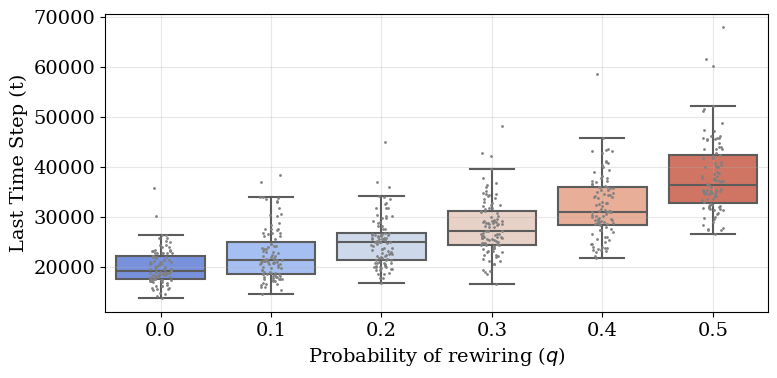

In [78]:
plt.figure(figsize=(8,4))
# generate a color palette with Seaborn.color_palette()
pal = sns.color_palette(palette='coolwarm', n_colors=6)

sns.boxplot(x='Epsilon', y='Time Step (t)', data=max_t_log_df, palette=pal, showfliers=False) 
sns.stripplot(x='Epsilon', y='Time Step (t)', data=max_t_log_df, size=2, color = 'gray')

plt.ylabel('Last Time Step (t)')
plt.xlabel('Probability of rewiring ($q$)')

plt.grid(alpha=.3)

plt.tight_layout()
plt.savefig('../figures/main/rewiring/last_time_step_analysis.pdf')
plt.show()

## Rewiring with Bounded Confidence